# Classification of CIFAR-10 dataset via deep convalutional neural network

Load CIFAR-10 dataset

In [1]:
import tarfile, os
from urllib.request import urlretrieve

path = "_data"
tarname='cifar-10-python.tar.gz'
url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

if not os.path.exists(path):
    os.mkdir(path)

urlretrieve(url, os.path.join(path, tarname))
tfile = tarfile.open(os.path.join(path, tarname))
tfile.extractall(path)

Get the train and the test parts of CIFAR-10 dataset

In [13]:
import numpy as np
import pickle, os


def get_data_and_labels(path):
    file = open(path, 'rb')
    content = pickle.load(file, encoding='latin1')
    data = content['data'].reshape([-1, 3, 32, 32]).astype('float32') / 255
    labels = np.array(content['labels'])
    return data, labels

#get X_train and y_train
X_train = []
y_train = []
for i in range(1,6):
    path = '_data/cifar-10-batches-py/data_batch_' + str(i)
    data, labels = get_data_and_labels(path)
    X_train.append(data)
    y_train.append(labels)
X_train = np.array(X_train).reshape(50000, 3, 32, 32)
y_train = np.array(y_train).reshape(50000)

#get X_test and y_test
path = '_data/cifar-10-batches-py/test_batch'
X_test, y_test = get_data_and_labels(path)

print(f'X_train.shape: {X_train.shape}, y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}, y_test.shape: {y_test.shape}')

X_train.shape: (50000, 3, 32, 32), y_train.shape: (50000,)
X_test.shape: (10000, 3, 32, 32), y_test.shape: (10000,)


Visualize some part of the dataset

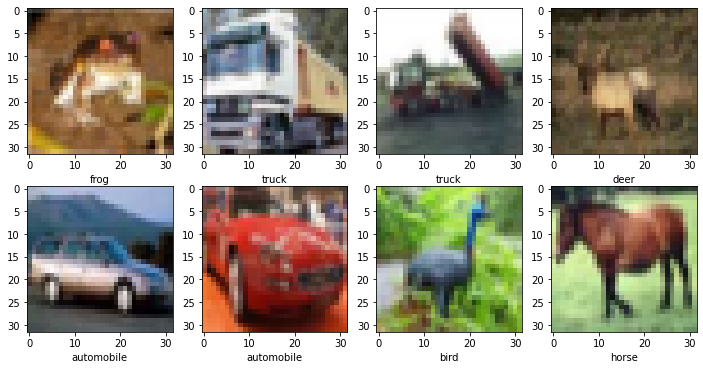

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=[12,6])
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xlabel(class_names[y_train[i]])
    plt.imshow(np.transpose(X_train[i],[1,2,0]))

Adding transformed images to the train part

In [15]:
import torch
import torch.nn as nn
from torchvision import transforms

transforms = nn.Sequential(
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
)

scripted_transforms = torch.jit.script(transforms)

transformed_X_train, transformed_y_train = [], []
for image, target in zip(X_train, y_train):
    image = torch.FloatTensor(image)
    transformed_image = scripted_transforms(image)
    transformed_image = transformed_image.numpy()
    transformed_X_train.append(transformed_image)
    transformed_y_train.append(target)

transformed_X_train = np.vstack((X_train, np.array(transformed_X_train)))
transformed_y_train = np.hstack((y_train, np.array(transformed_y_train)))

print(f'transformed_X_train.shape: {transformed_X_train.shape}, \
transformed_y_train.shape: {transformed_y_train.shape}')

transformed_X_train.shape: (100000, 3, 32, 32), transformed_y_train.shape: (100000,)


Determine the class of model

In [16]:
import torch.nn.functional as F


class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.dense1 = nn.Linear(64 * 6 * 6, 1024)
        self.dense2 = nn.Linear(1024, 10)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.5)
        
        self.batch_size = 50
        self.optimazer = torch.optim.SGD(self.parameters(), lr=0.01)
        return None
        
    def forward(self, input):
        hidden = self.conv1(input)
        hidden = self.batchnorm1(hidden)
        hidden = self.relu(hidden)
        hidden = self.maxpool(hidden)
        
        hidden = self.conv2(hidden)
        hidden = self.batchnorm2(hidden)
        hidden = self.relu(hidden)
        hidden = self.maxpool(hidden)
        
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.dense1(hidden)
        hidden = self.relu(hidden)
        hidden = self.dropout(hidden)
        hidden = self.dense2(hidden)
        return hidden
    
    def fit(self, X_train, y_train):
        self.train(True)
        
        train_size = X_train.shape[0]
        
        #shuffle indices
        indices = np.arange(train_size)
        indices = np.random.permutation(indices)
        
        for start in range(0, train_size, self.batch_size):
            
            #get minibatch
            batch_indices = indices[start: start + self.batch_size]
            X_batch = X_train[batch_indices]
            y_batch = y_train[batch_indices]
            
            #calculate loss
            X_batch = torch.FloatTensor(X_batch)
            y_batch = torch.LongTensor(y_batch)
            logits = self.forward(X_batch)
            loss = F.cross_entropy(logits, y_batch).mean()
            
            #update parameters
            loss.backward()
            self.optimazer.step()
            self.optimazer.zero_grad()
        
        return loss
    
    def test(self, X_test, y_test):
        self.train(False)
        
        X_test = torch.FloatTensor(X_test)
        logits = self.forward(X_test).data.numpy()
        y_pred = np.argmax(logits, axis=1)
        return np.mean(y_test == y_pred)

Determine the class of Visualizer

In [23]:
import time
from IPython.display import clear_output


class Visualizer():
    def __init__(self):
        self.loss_values = []
        self.accuracy_values = []
        self.start_time = time.time()
        return None
    
    def show(self, loss, accuracy, epoch):
        clear_output(True)
        
        loss = loss.data.numpy().reshape(1)[0]
        print('epoch: {}, accuracy: {:.2f}%, loss: {:.2f}, epoch time: {:.2f}s'.format(
        epoch + 1, accuracy * 100, loss, time.time() - self.start_time))
        if len(self.accuracy_values) > 0:
            print('best accuracy: {:.2f}%'.format(max(self.accuracy_values) * 100))
        
        self.loss_values.append(loss)
        self.accuracy_values.append(accuracy)
        
        plt.figure(figsize=[10,5])
        if len(self.loss_values) > 0:
            plt.plot(self.loss_values / max(self.loss_values), 'b', label='normalized loss')
        plt.plot(self.accuracy_values, 'r', label='accuracy')
        plt.title('Learning progress')
        plt.xlabel('Epoch')
        plt.grid()
        plt.legend()
        plt.show()
        
        self.start_time = time.time()
        return None

Train the model

epoch: 100, accuracy: 79.25%, loss: 0.10, epoch time: 78.57s
best accuracy: 79.53%


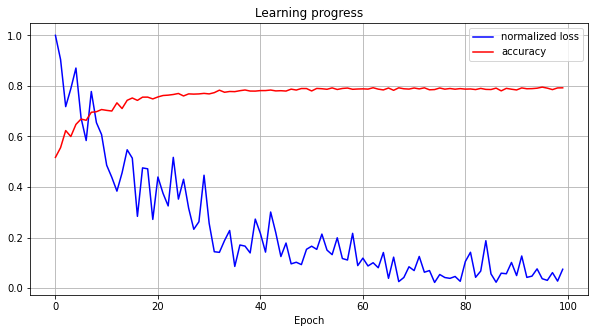

In [24]:
nn_model = NNModel()
visualizer = Visualizer()

n_epochs = 100
loss_values, accuracy_values = [], []
for epoch in range(n_epochs):
    loss = nn_model.fit(transformed_X_train, transformed_y_train)
    accuracy = nn_model.test(X_test, y_test)
    visualizer.show(loss, accuracy, epoch)